In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Use retina mode
%config InlineBackend.figure_format = 'retina'

from scipy.ndimage import uniform_filter1d

def smooth(x):
    return uniform_filter1d(x, 10)

In [3]:
def load_log(QID, acc_dir, entropy_dir, entropy_pattern, include_ans=False):
    tmp_dir = acc_dir
    entropy_base_dir = entropy_dir

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, entropy_pattern.format(QID))
    )

    if include_ans:
        ANS = np.load(
            os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
        )
        ua = []
        for _A in ANS:
            ua.append(len(np.unique(_A)))
        return ACC, ENTROPY, np.array(ua), ANS
    
    return ACC, ENTROPY

In [4]:
def moving_median(data, window_size):
    if not isinstance(data, np.ndarray) or data.ndim != 1:
        raise TypeError("Input 'data' must be a 1D NumPy array.")
    if not isinstance(window_size, int) or window_size <= 0:
        raise ValueError("Input 'window_size' must be a positive integer.")
    if window_size > len(data):
        raise ValueError("'window_size' cannot be larger than the data length.")
    if window_size % 2 == 0:
        print("Warning: For a true median, the window size should be odd. "
              "Using an even window size will result in a non-standard median calculation.")

    # --- Moving Median Calculation ---
    # The number of elements in the output array
    output_len = len(data) - window_size + 1
    
    # Initialize an empty array to store the results
    medians = np.empty(output_len)

    # Slide the window across the data
    for i in range(output_len):
        # Extract the current window from the data
        window = data[i : i + window_size]
        
        # Calculate the median of the window and store it
        medians[i] = np.median(window)

    return medians

In [5]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def compute_relative_changes(a):
    """
    Compute the relative changes of a sequence with a moving average window.
    """
    return np.abs(
        (a[1:] - a[:-1])
    )


def get_early_stop_point_posthoc(trace, threshold, min_distance=25):
    trace = trace[1:]
    for i, value in enumerate(trace):
        if i < min_distance:
            continue
        if value < threshold:
            return i
    return None

def exponential_moving_average(data, timescale):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    
    for i in range(1, len(data)):
        ema[i] = timescale * data[i] + (1 - timescale) * ema[i - 1]
    
    return ema

def exponential_moving_variance(data, timescale, ema_0=0.0):
    ema_mean = exponential_moving_average(data, timescale)
    ema_variance = np.zeros_like(data)
    ema_variance[0] = ema_0
    
    for i in range(1, len(data)):
        deviation = data[i] - ema_mean[i]
        ema_variance[i] = timescale * (deviation ** 2) + (1 - timescale) * ema_variance[i - 1]

    return ema_variance

def simple_moving_average_variance(data, window_size=10):
    window = np.ones(window_size) / window_size
    mean_x = np.convolve(data, window, mode='valid')
    mean_x_sq = np.convolve(data**2, window, mode='valid')
    moving_var = mean_x_sq - mean_x**2
    # Pad the beginning of the moving variance to match the length of the original data
    moving_var = np.concatenate((np.zeros(window_size - 1), moving_var))
    return moving_var

def choose_early_stop_point(entropy, timescale, threshold, min_distance=25, ema_0=0.0, min_value_threshold=None):
    ema_variance = exponential_moving_variance(entropy, timescale, ema_0)
    if min_distance > len(entropy):
        return -1
    if min_value_threshold is not None:
        min_value_pos = np.argmax(entropy < min_value_threshold)
        min_distance = max(min_value_pos, min_distance)
    exit_idx = get_early_stop_point_posthoc(ema_variance, threshold, min_distance)
    return exit_idx if exit_idx is not None else -1

def choose_early_stop_point_moving_window(entropy, window_size, threshold):
    if window_size > len(entropy):
        return -1
    ema_variance = simple_moving_average_variance(entropy, window_size)
    exit_idx = get_early_stop_point_posthoc(ema_variance, threshold, window_size)
    return exit_idx if exit_idx is not None else -1

# Figure for the paper

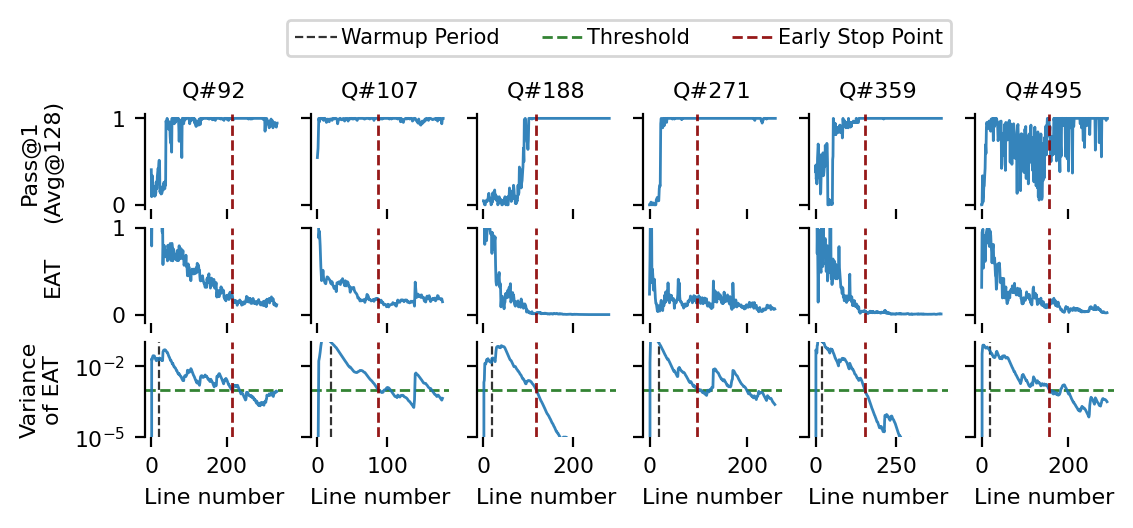

In [420]:
QIDs = [92, 107, 188, 271, 359, 495]
acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

line_config = {
    'linewidth': 1.0, 'alpha': 0.9,
}

LF_SIZE = 8

fig, ax = plt.subplots(
    3, len(QIDs),
    figsize=(6.25, 2.1),
    sharex='col', sharey='row'
)

T = 1e-3
TS = 0.1


for a in ax[2]:
    a.axvline(2 / TS, color='black', linestyle='--', linewidth=0.8, alpha=0.8, label='Warmup Period')
    a.axhline(T, linestyle='--', linewidth=1.0, alpha=0.8, color='darkgreen', label='Threshold')
    a.set_xlabel('Line number', fontsize=LF_SIZE)

for i, QID in enumerate(QIDs):
    acc, ent, ua, ans = load_log(
        QID,
        acc_dir,
        entropy_dir,
        'entropy_{}_new_dpsk_new_with_sample_ngram.npy',
        include_ans=True
    )
    E = ent[:, 1]
    ax[0, i].plot(acc, **line_config)
    ax[1, i].plot(E, **line_config)
    VAR = exponential_moving_variance(E, TS, ema_0=0.0)
    ax[2, i].plot(VAR, **line_config)
    ax[0, i].set_title(f'Q#{QID}', fontsize=LF_SIZE)
    stop_point = choose_early_stop_point(
        E, TS, T, min_distance=2 / TS, ema_0=0.0
    )
    ax[0, i].axvline(stop_point, color='darkred', linestyle='--', linewidth=1.0, alpha=0.9)
    ax[1, i].axvline(stop_point, color='darkred', linestyle='--', linewidth=1.0, alpha=0.9)
    ax[2, i].axvline(stop_point, color='darkred', linestyle='--', linewidth=1.0, alpha=0.9, label='Early Stop Point')


ax[1, 0].set_ylim(-0.1, 1.0)
ax[2, 0].set_yscale('log')
ax[2, 0].set_ylim(1e-5, 1e-1)



ax[0,0].set_ylabel('Pass@1\n(Avg@128)', fontsize=LF_SIZE)
ax[1,0].set_ylabel('EAT', fontsize=LF_SIZE)
ax[2,0].set_ylabel("Variance\nof EAT", fontsize=LF_SIZE)

fig.align_ylabels(ax[:, 0])

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=LF_SIZE - 0.1, axis='both')

ax[2, 0].legend(
    loc='upper right', fontsize=LF_SIZE - 0.5, ncol=3,
    frameon=True, handlelength=2.0, handletextpad=0.2,
    bbox_to_anchor=(5.9, 4.5)
)

fig.savefig('/root/figures/early_stop_illustration.pdf', bbox_inches='tight')

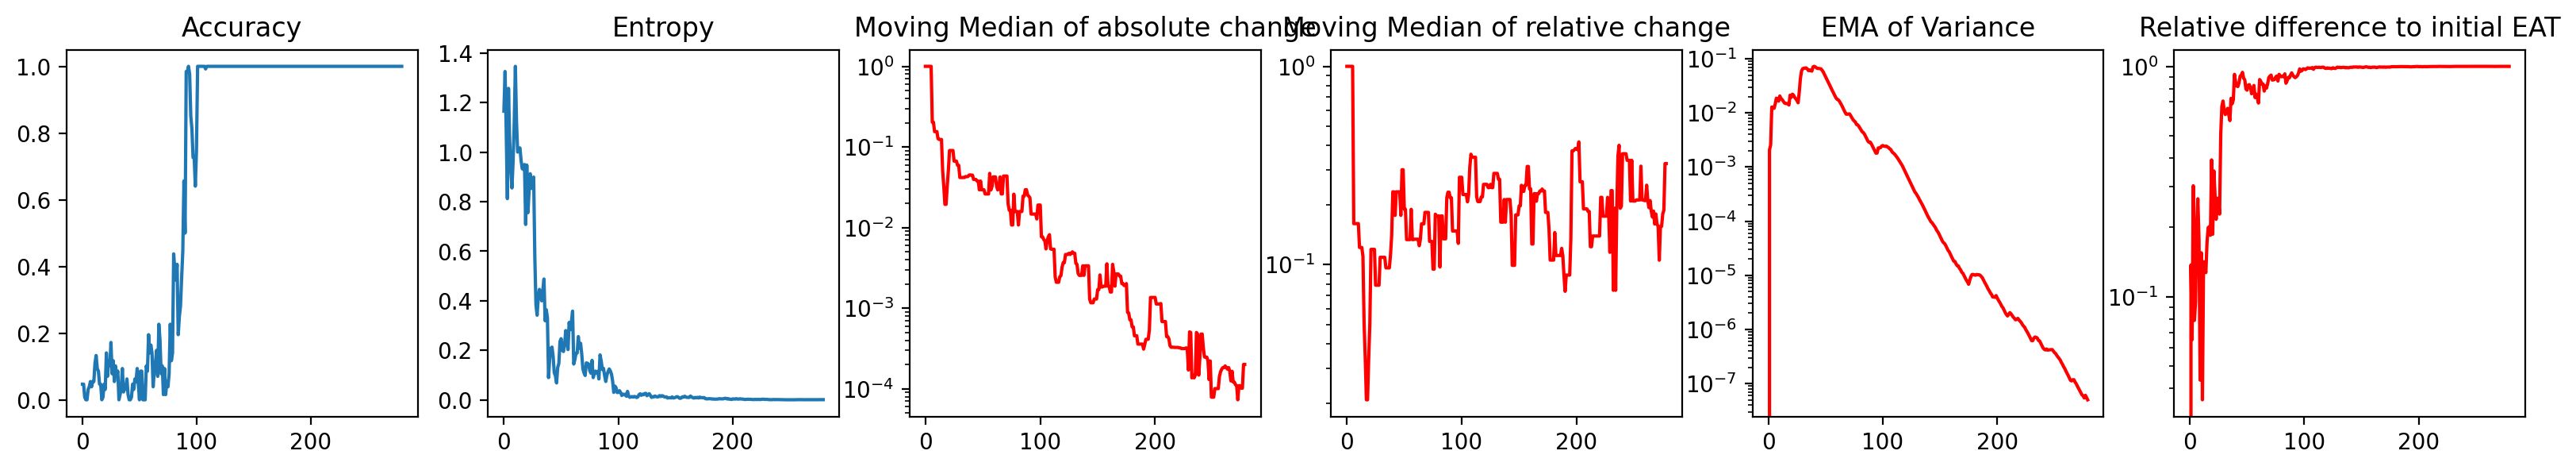

In [79]:
acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
QID = 188
acc, ent, ua, ans = load_log(
    QID,
    acc_dir,
    entropy_dir,
    'entropy_{}_new_dpsk_new_with_sample_ngram.npy',
    include_ans=True
)
line_config = {
        'linewidth': 1.0, 'alpha': 0.8,
        'marker': 'o', 'markersize': 1,
    }

alpha = 0.1
fig, ax = plt.subplots(
    1, 6,
    figsize=(20, 3)
)
E = ent[:, 1]

ax[0].plot(acc)
ax[1].plot(E)

ax[0].set_title('Accuracy')
ax[1].set_title('Entropy')
ax[2].set_title('Moving Median of absolute change')
ax[3].set_title('Moving Median of relative change')
ax[4].set_title('EMA of Variance')
ax[5].set_title('Relative difference to initial EAT')

metric_color = 'red'

WINDOW_SIZE = 7
rt = moving_median(np.abs((E[1:] - E[:-1])), WINDOW_SIZE)
rt = np.concatenate((np.ones(WINDOW_SIZE - 1), rt))


ax[2].plot(rt, c=metric_color)
ax[2].set_yscale('log')


rt = moving_median(np.abs((E[1:] - E[:-1]) / E[:-1]), WINDOW_SIZE)
rt = np.concatenate((np.ones(WINDOW_SIZE - 1), rt))
ax[3].plot(rt, c=metric_color)
ax[3].set_yscale('log')

ax[4].plot(exponential_moving_variance(E, 0.1), c=metric_color)
ax[4].set_yscale('log')

rt = np.abs((E - E[0]) / E[0])
ax[5].plot(rt, c=metric_color)
ax[5].set_yscale('log')



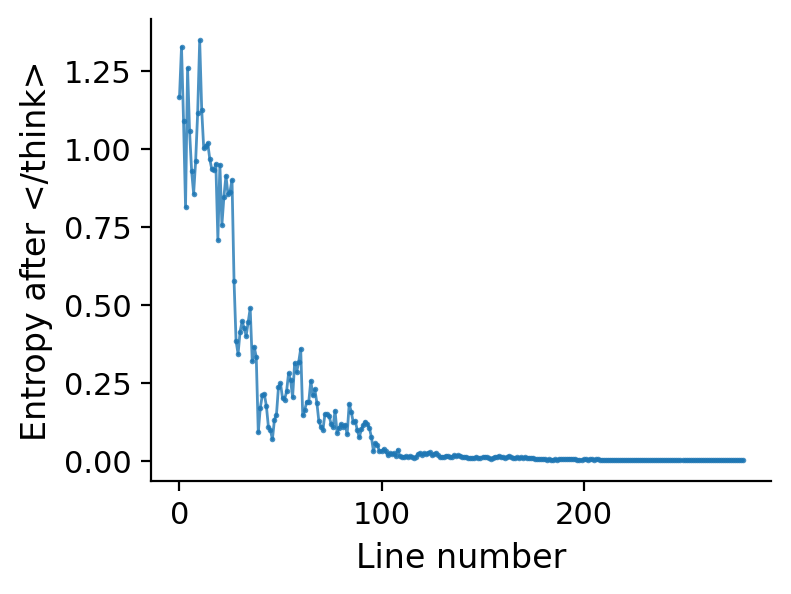

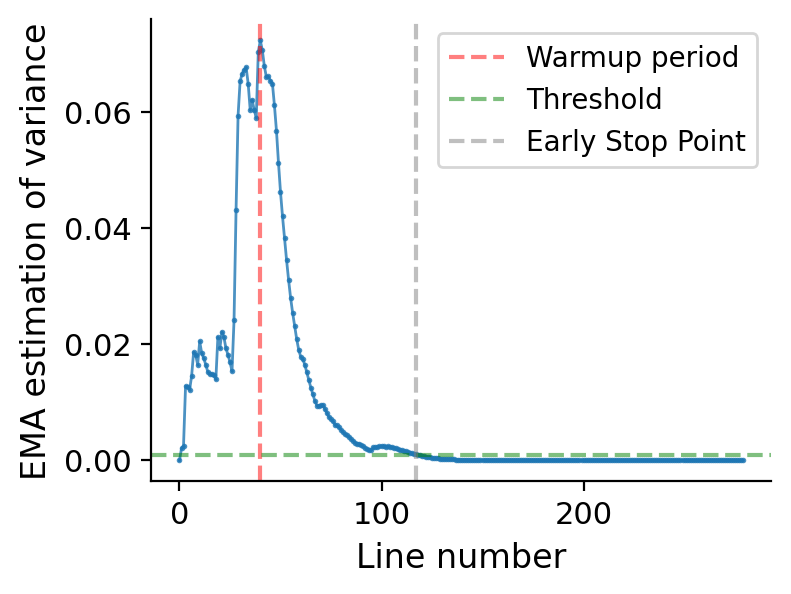

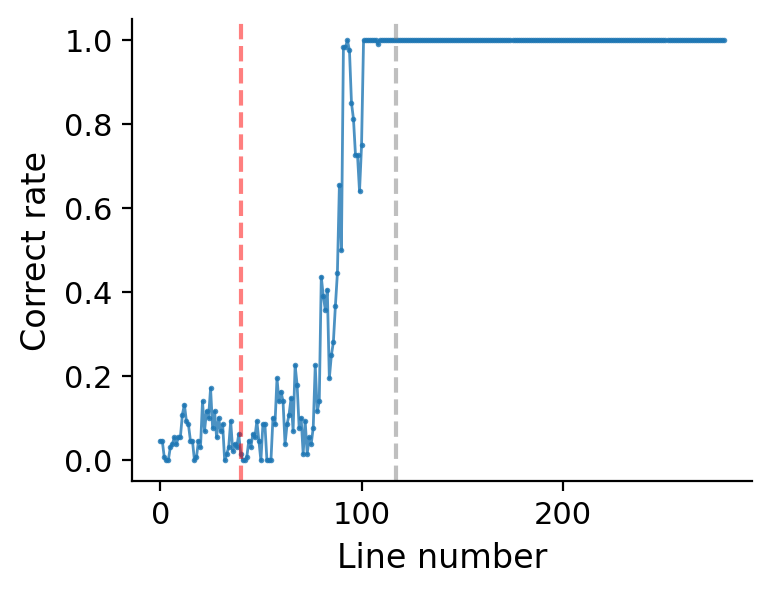

In [5]:
acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

QID = 188

acc, ent, ua, ans = load_log(
    QID,
    acc_dir,
    entropy_dir,
    'entropy_{}_new_dpsk_new_with_sample_ngram.npy',
    include_ans=True
)

line_config = {
        'linewidth': 1.0,
        'alpha': 0.8,
        'marker': 'o',
        'markersize': 1,
    }

alpha = 0.1

ema_var = exponential_moving_variance(ent[:, 1], alpha, ema_0=0.0)
# ema_var = simple_moving_average_variance(ent[:, 1], window_size=20)

ax = []
for i in range(3):
    fig, _ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.append(_ax)

ax[0].plot(ent[:, 1], label='unigram', **line_config)
ax[1].plot(ema_var, **line_config)
ax[2].plot(acc, label='bigram', **line_config)
ax[1].axvline(4 / alpha, color='red', linestyle='--', alpha=0.5, label='Warmup period')
ax[2].axvline(4 / alpha, color='red', linestyle='--', alpha=0.5, label='Warmup period')
ax[1].axhline(2**-10, color='green', linestyle='--', alpha=0.5, label='Threshold')

SP = get_early_stop_point_posthoc(ema_var, 2**-10, min_distance=4 / alpha)
ax[1].axvline(SP, color='gray', linestyle='--', alpha=0.5, label='Early Stop Point')
ax[2].axvline(SP, color='gray', linestyle='--', alpha=0.5, label='Early Stop Point')
ax[1].legend(fontsize=10)

LF_SIZE = 12
ax[0].set_ylabel('Entropy after </think>', fontsize=LF_SIZE)
ax[1].set_ylabel('EMA estimation of variance', fontsize=LF_SIZE)
ax[2].set_ylabel('Correct rate', fontsize=LF_SIZE)


for a in ax:
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Line number', fontsize=LF_SIZE)
    a.tick_params(labelsize=LF_SIZE - 1.0, axis='both')

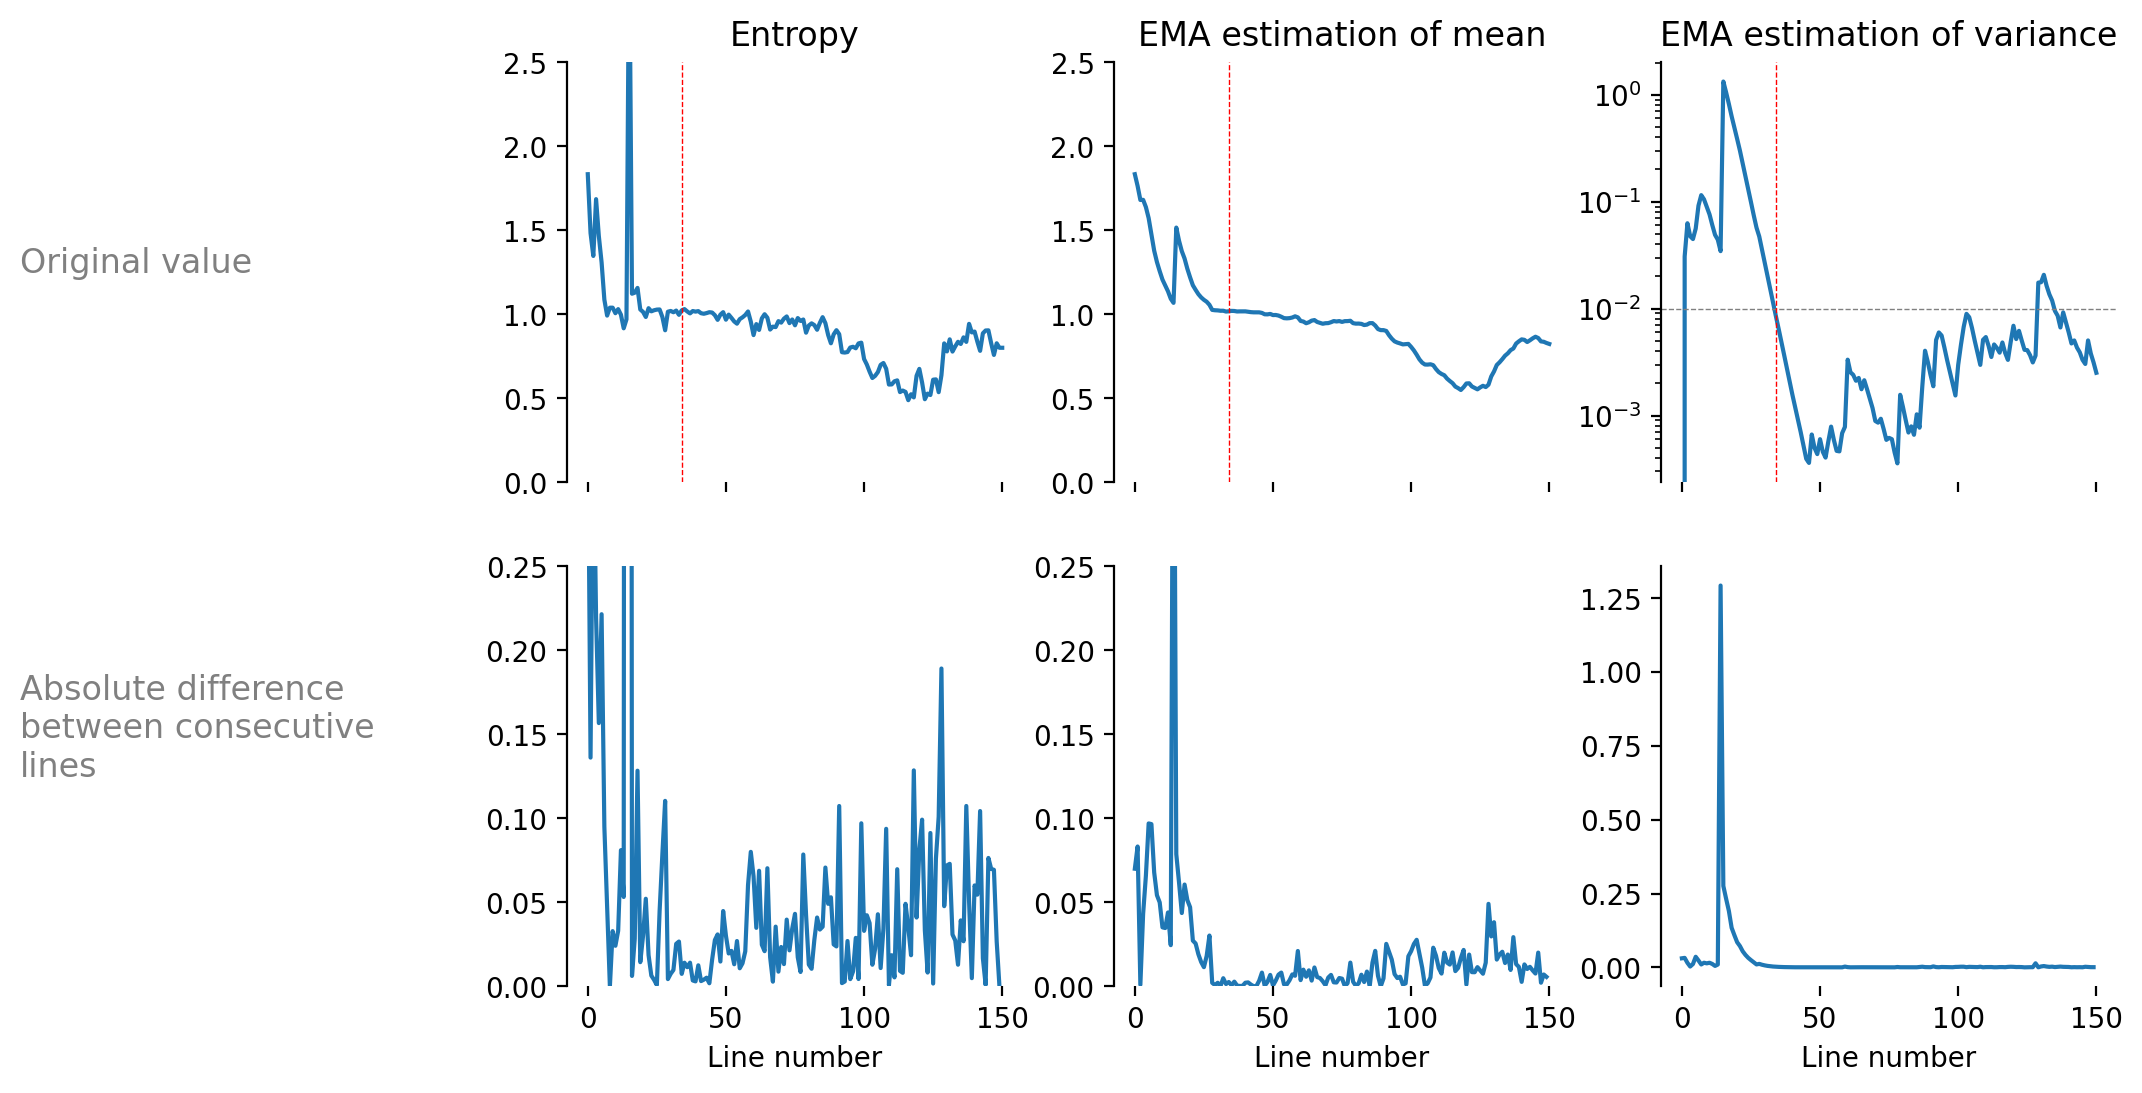

In [249]:
entropy_base_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
QID = 4
QID = 30
ENTROPY = (np.load(
    os.path.join(entropy_base_dir, f'entropy_{QID}.npy')
)[:, 0])

fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharex=True)

for a in ax[1, :]:
    a.set_xlabel('Line number')

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)

    # a.set_xlim(0, 75)

ax[0, 0].plot(ENTROPY)
ax[0, 0].set_title('Entropy')
ax[0, 0].set_ylim(0, 2.5)

ema_mean = exponential_moving_average(ENTROPY, 0.2)
ax[0, 1].plot(ema_mean)
ax[0, 1].set_title('EMA estimation of mean')
ax[0, 1].set_ylim(0, 2.5)

ema_variance = exponential_moving_variance(ENTROPY, 0.25)
ax[0, 2].plot(ema_variance)
ax[0, 2].set_title('EMA estimation of variance')

ax[1, 0].plot(np.abs(ENTROPY[1:] - ENTROPY[:-1]))
ax[1, 1].plot(np.abs(ema_mean[1:] - ema_mean[:-1]))
ax[1, 2].plot(np.abs(ema_variance[1:] - ema_variance[:-1]))

ax[0, 0].text(-1.2, 0.5, f'Original value', fontsize=12, color='gray', transform=ax[0, 0].transAxes)
ax[1, 0].text(-1.2, 0.5, f'Absolute difference\nbetween consecutive\nlines', fontsize=12, color='gray', transform=ax[1, 0].transAxes)

ax[1, 0].set_ylim(0, 0.25)
ax[1, 1].set_ylim(0, 0.25)
# ax[1, 1]
ax[0, 2].set_yscale('log')
ax[0, 2].axhline(0.01, color='gray', linestyle='--', linewidth=0.5)

stop_idx = get_early_stop_point_posthoc(ema_variance, 0.01)
ax[0, 2].axvline(stop_idx, color='red', linestyle='--', linewidth=0.5)
ax[0, 1].axvline(stop_idx, color='red', linestyle='--', linewidth=0.5)
ax[0, 0].axvline(stop_idx, color='red', linestyle='--', linewidth=0.5)

(0.0, 2.5)

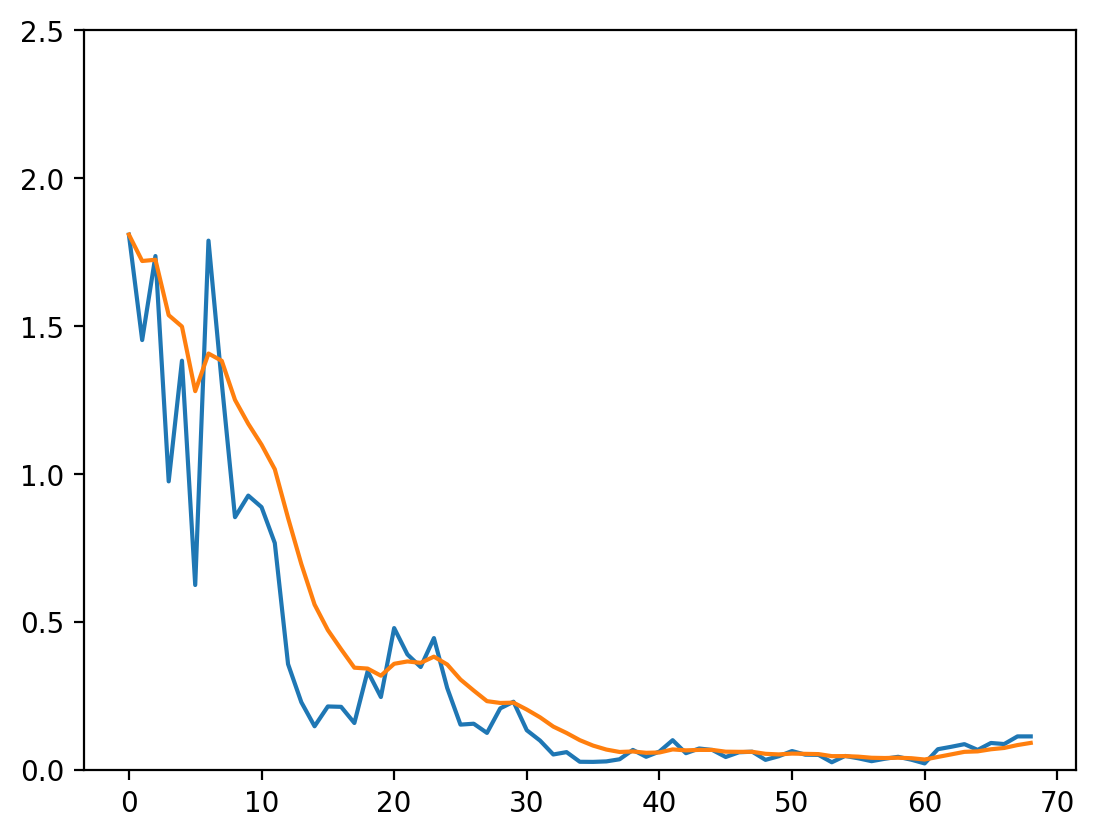

In [164]:
entropy_base_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
QID = 187
ENTROPY = (np.load(
    os.path.join(entropy_base_dir, f'entropy_{QID}.npy')
)[:, 0])
plt.plot(ENTROPY)
plt.plot(exponential_moving_average(ENTROPY, 0.25))
plt.ylim(0.0, 2.5)
# plt.yscale('log')

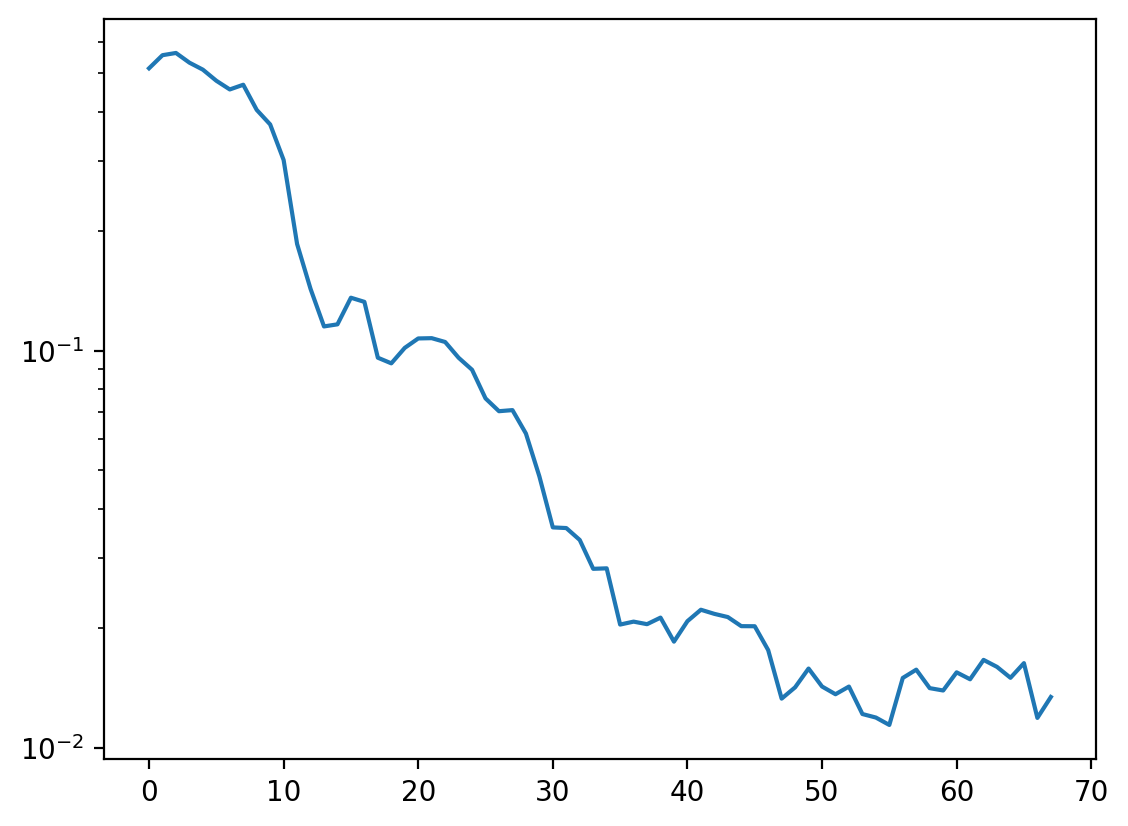

In [158]:
rol = np.abs((ENTROPY[1:] - ENTROPY[:-1]))
# plt.ylim(0.001, 0.4)
plt.yscale('log')
plt.plot(smooth(rol))
